### Measure shear estimator statistical errors using field shear correlations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser

from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()
from wlenet.cluster.cluster_lensing import ClusterLensing
from wlenet.cluster.cluster_survey import ClusterSurvey
from wlenet.cluster.shear_stamps import ShearEstimatorCnn
from wlenet.cluster.shear_fields import ShearFieldEstimator
from wlenet.cluster.figures import show_survey_shear_fields
from wlenet.models.utils import load_spec
from wlenet.models.calibrate import step_bias_compose
from wlenet.misc.sampling import sample_image

In [2]:
seed = 1234
save_figures = True
hold_out_ratio = 0.5
bootstrap_iters = 100

In [3]:
r_smoothings = np.array([10.0, 20.0, 30.0, 40.0])
sse_names = ['cat', 'cnn']

In [4]:
sfe_name = 'r_smoothing_XX'

In [5]:
model_spec_cnn = load_spec('cnn_image_clash_uniform_mse_lsq')
calib_clash_cnn_to_rrg = np.load(expanduser(config['estimation_path'] + '/clash_biases.npy'))
model_spec_cnn['calib'] = step_bias_compose(model_spec_cnn['calib'], calib_clash_cnn_to_rrg)

In [6]:
def cluster_stats(cluster, sse_names):

    scale_factor = cluster.field_shear_estimators[sfe_name].scale_factor
    held_out_inds = cluster.shear_fields[sfe_name]['held_out_inds']
    
    g_src = np.zeros((len(sse_names), len(held_out_inds), 2))
    g_mean = np.zeros(g_src.shape)
    g_var = np.zeros(g_src.shape)
    
    for i, sse_name in enumerate(sse_names):

        xy = cluster.cut['xy'][held_out_inds, :] * scale_factor          
        g_src[i,:,:] = cluster.cut['shears_' + sse_name][held_out_inds, :]
      
        sf_mean = cluster.shear_fields[sfe_name][sse_name]['mean']
        sf_cov = cluster.shear_fields[sfe_name]['cov']
        
        g_mean[i,:,:] = np.column_stack((sample_image(sf_mean[0,:,:], xy[:,0], xy[:,1]),
                                         sample_image(sf_mean[1,:,:], xy[:,0], xy[:,1])))    
        g_var[i,:,:] = np.column_stack((sample_image(sf_cov[0,:,:,i,i], xy[:,0], xy[:,1]),
                                        sample_image(sf_cov[1,:,:,i,i], xy[:,0], xy[:,1])))
    return g_src, g_mean, g_var


def survey_stats(survey, sse_names):
    
    g_src = np.zeros((len(sse_names),0,2))
    g_mean = np.zeros((len(sse_names),0,2))
    g_var = np.zeros((len(sse_names),0,2))

    for cluster in survey.clusters:

        g_src_, g_mean_, g_var_ = cluster_stats(cluster, sse_names)
        g_src = np.append(g_src, g_src_, axis=1)
        g_mean = np.append(g_mean, g_mean_, axis=1)
        g_var = np.append(g_var, g_var_, axis=1)        

    return g_src, g_mean, g_var

In [7]:
%%capture

field_stds = np.zeros((len(r_smoothings), len(sse_names)))
delta_stds = np.zeros((len(r_smoothings), len(sse_names)))

for i, r_smoothing in enumerate(r_smoothings):

    stamp_shear_estimators = {'cnn': ShearEstimatorCnn(model_spec_cnn)}
    field_shear_estimators = {sfe_name: ShearFieldEstimator(sse_names=sse_names, r_smoothing=r_smoothing, 
                                                            bootstrap_iters=bootstrap_iters, 
                                                            hold_out_ratio=hold_out_ratio, 
                                                            seed=seed, fields_cutoff=False)}
    
    survey = ClusterSurvey(ClusterLensing(cut_params={'apply_extra_cut': True}, 
                                          stamp_shear_estimators=stamp_shear_estimators,
                                          field_shear_estimators=field_shear_estimators))
    survey.process_survey()
    survey.remove_tmp_files()
    
    g_src, g_mean, g_var = survey_stats(survey, sse_names)
    
    field_stds[i, :] = np.nanmean(g_var, axis=(1,2))**0.5  
    delta_stds[i, :] = np.nanmean((g_src - g_mean)**2, axis=(1,2))**0.5

In [8]:
cat_field               = field_stds[:, 0]
cat_scatter             = delta_stds[:, 0]
cat_scatter_minus_field = (cat_scatter**2 - cat_field**2)**0.5
cnn_field               = field_stds[:, 1]
cnn_scatter             = delta_stds[:, 1]
cnn_scatter_minus_field = (cnn_scatter**2 - cnn_field**2)**0.5

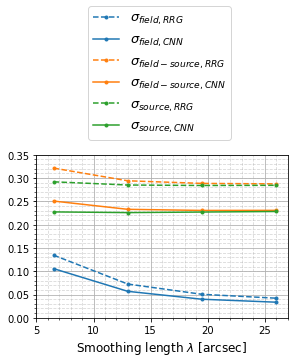

In [9]:
fig = plt.figure(figsize=(5.5,3.66))
pixel_scale = 0.065*10
r_smoothings_arcsec = np.array(r_smoothings) * pixel_scale

plt.plot(r_smoothings_arcsec, cat_field, '.--', color='C0', label='$\sigma_{field,RRG}$')
plt.plot(r_smoothings_arcsec, cnn_field, '.-', color='C0', label='$\sigma_{field,CNN}$')

plt.plot(r_smoothings_arcsec, cat_scatter, '.--', color='C1', label='$\sigma_{field-source,RRG}$')
plt.plot(r_smoothings_arcsec, cnn_scatter, '.-', color='C1', label='$\sigma_{field-source,CNN}$')

plt.plot(r_smoothings_arcsec, cat_scatter_minus_field, '.--', color='C2', label='$\sigma_{source,RRG}$')
plt.plot(r_smoothings_arcsec, cnn_scatter_minus_field, '.-', color='C2', label='$\sigma_{source,CNN}$')

plt.legend(bbox_to_anchor=(0.80,1.95), prop={'size': 13})
plt.xlabel('Smoothing length $\lambda$ [arcsec]', fontsize=12)
plt.ylim([0,0.35])
plt.xlim([5,27])
plt.grid('on')
plt.grid('on', which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/estimation/clash_error_analysis.pdf')
    plt.savefig(fig_path, bbox_inches='tight')

In [10]:
np.mean(cnn_scatter_minus_field), np.std(cnn_scatter_minus_field)

(0.22704339723160155, 0.0008567816144695369)

In [11]:
np.mean(cat_scatter_minus_field), np.std(cat_scatter_minus_field)

(0.286287248960021, 0.003224898624189697)

In [16]:
np.mean(cat_scatter_minus_field) / np.mean(cnn_scatter_minus_field)

1.2609362458930538